In [7]:
import operator
from typing import Callable, List

import matplotlib.pyplot as plt
import numpy as np
from fastai.basic_data import DataBunch, DatasetType
from fastai.metrics import accuracy
from fastai.train import Learner
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils as utils
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import pandas as pd

from raw_dataset import RawDataset
from processed_dataset import ProcessedDataset
from split_dataset import SplitDataset
from nn_toolkit.vocab import Vocab, VocabBuilder

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
raw = RawDataset()
processed = ProcessedDataset(raw)
processed.process()
split_ds = SplitDataset(processed)

In [44]:
vocab = VocabBuilder(max_size=20000, min_count=3).from_df(split_ds.train_df, ['tokens', 'location_tokens'])
split_ds.train_df['int_tokens'] = split_ds.train_df.tokens.apply(vocab.map_to_ints)
split_ds.val_df['int_tokens'] = split_ds.val_df.tokens.apply(vocab.map_to_ints)
split_ds.test_df['int_tokens'] = split_ds.test_df.tokens.apply(vocab.map_to_ints)

split_ds.train_df['int_location'] = split_ds.train_df.location_tokens.apply(vocab.map_to_ints)
split_ds.val_df['int_location'] = split_ds.val_df.location_tokens.apply(vocab.map_to_ints)
split_ds.test_df['int_location'] = split_ds.test_df.location_tokens.apply(vocab.map_to_ints)

In [85]:
class SimpleDataset(utils.data.Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df
        self.classes = [0, 1]
        self.c = len(self.classes)
        self.maxlen = 128
        self.pad_val = 0
        
    def __getitem__(self, idx: int):
        sample = self.df.iloc[idx]
        tokens = self.get_tokens(sample)
        label = self.get_label(sample)
        return tokens, label
    
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def get_tokens(self, sample: pd.Series) -> torch.LongTensor:
        tokens = sample.int_tokens
        tokens = self._pad_sequence(tokens)
        return torch.LongTensor(tokens)
    
    def get_label(self, sample: pd.Series) -> torch.Tensor:
        return torch.LongTensor([sample.target])
    
    def _pad_sequence(self, seq: List) -> List:
        diff = self.maxlen - len(seq)
        return [self.pad_val]*diff + seq

def collate_simple(batch: List):
    xb = torch.stack([sample[0] for sample in batch])
    yb = torch.cat([sample[1] for sample in batch])
    return xb, yb


def create_simple_databunch(split_ds):
    train_ds = SimpleDataset(split_ds.train_df)
    val_ds = SimpleDataset(split_ds.val_df)
    test_ds = SimpleDataset(split_ds.test_df)

    data = DataBunch.create(train_ds, val_ds, test_ds, collate_fn=collate_simple)
    return data

In [83]:
class MultiDataset(utils.data.Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df
        self.classes = [0, 1]
        self.c = len(self.classes)
        self.maxlen = 128
        self.pad_val = 0
        
    def __getitem__(self, idx: int):
        sample = self.df.iloc[idx]
        tokens = self.get_tokens(sample)
        label = self.get_label(sample)
        return tokens, label
    
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def get_tokens(self, sample: pd.Series) -> torch.LongTensor:
        text = sample.int_tokens
        location = sample.int_location
        text = torch.LongTensor(self._pad_sequence(text))
        location = torch.LongTensor(self._pad_sequence(location))
        return {'text': text, 'location': location}
    
    def get_label(self, sample: pd.Series) -> torch.Tensor:
        return torch.LongTensor([sample.target])
    
    def _pad_sequence(self, seq: List) -> List:
        diff = self.maxlen - len(seq)
        return [self.pad_val]*diff + seq

def collate_multi(batch: List):
    text = torch.stack([sample[0]['text'] for sample in batch])
    location = torch.stack([sample[0]['location'] for sample in batch])
    xb = {'text': text, 'location': location}
    yb = torch.cat([sample[1] for sample in batch])
    return xb, yb

def create_multi_databunch(split_ds):
    train_ds = MultiDataset(split_ds.train_df)
    val_ds = MultiDataset(split_ds.val_df)
    test_ds = MultiDataset(split_ds.test_df)

    data = DataBunch.create(train_ds, val_ds, test_ds, collate_fn=collate_multi)
    return data

In [84]:
simple_data = create_simple_databunch(split_ds)
multi_data = create_multi_databunch(split_ds)
simple_data.one_batch()

AttributeError: 'DataFrame' object has no attribute 'target'

In [71]:
multi_data.one_batch()

({'text': tensor([[ 0,  0,  0,  ..., 82, 56,  3],
          [ 0,  0,  0,  ..., 44, 45,  3],
          [ 0,  0,  0,  ..., 44, 45,  3],
          ...,
          [ 0,  0,  0,  ..., 44, 45,  3],
          [ 0,  0,  0,  ..., 26, 26,  3],
          [ 0,  0,  0,  ..., 94, 26,  3]]),
  'location': tensor([[   0,    0,    0,  ...,  269,    1,    3],
          [   0,    0,    0,  ..., 3246, 1733,    3],
          [   0,    0,    0,  ..., 3266,   56,    3],
          ...,
          [   0,    0,    0,  ..., 3246, 4154,    3],
          [   0,    0,    0,  ..., 1615,    1,    3],
          [   0,    0,    0,  ..., 2858,  590,    3]])},
 tensor([0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
         1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
         0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0]))

In [52]:
class Encoder(nn.Module):
    def __init__(self, vocab: Vocab, hidden_size: int, num_layers: int) -> None:
        super().__init__()
        self.embedding_layer = nn.Embedding(
            vocab.size,
            hidden_size,
            padding_idx=0
        )
        self.rnn= nn.LSTM(
            hidden_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0.
        )
    
    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        emb = self.embedding_layer(X)
        emb, state = self.rnn(emb)
        return emb


class SimpleClassifier(nn.Module):
    def __init__(self, vocab: Vocab, hidden_size: int, num_layers: int) -> None:
        super().__init__()
        self.encoder = Encoder(vocab, hidden_size, num_layers)
        self.densor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)
        )
    
    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        emb = self.encoder(X)
        emb = emb[:, -1]
        logit = self.densor(emb)
        log_prob = F.log_softmax(logit, dim=-1)
        return log_prob

    
class MultiClassifier(nn.Module):
    def __init__(self, vocab: Vocab, hidden_size: int, num_layers: int) -> None:
        super().__init__()
        self.text_encoder = Encoder(vocab, hidden_size, num_layers)
        self.loc_encoder = Encoder(vocab, hidden_size, 1)
        self.scale = nn.Parameter(torch.scalar_tensor(1.))
        self.densor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 2)
        )

    def forward(self, X: dict) -> torch.FloatTensor:
        text = X['text']
        location = X['location']
        t_emb = self.text_encoder(text)
        l_emb = self.loc_encoder(location)
        last_t = t_emb[:, -1]
        last_l = t_emb[:, -1]
        emb = last_t + self.scale * last_l
        logit = self.densor(emb)
        log_prob = F.log_softmax(logit, dim=-1)
        return log_prob

In [53]:
_HIDDEN_SIZE = 128
_NUM_LAYERS = 2

In [21]:
model = SimpleClassifier(vocab, _HIDDEN_SIZE, _NUM_LAYERS)
learner = Learner(simple_data, model, loss_func=nn.NLLLoss(), opt_func=optim.Adam, metrics=[accuracy])

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


<IPython.core.display.Javascript object>


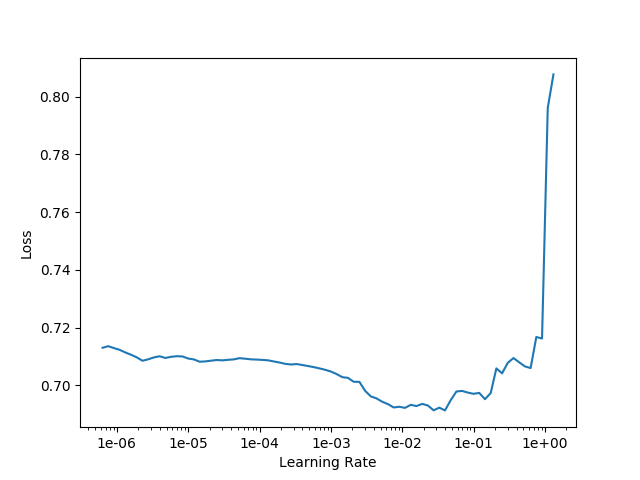

In [22]:
learner.lr_find()
learner.recorder.plot()

In [46]:
learner.fit_one_cycle(2, max_lr=1e-2)
learner.fit(15, 1e-3)

epoch     train_loss  valid_loss  accuracy  time    
0         0.617153    0.543464    0.731451  00:40     
1         0.476428    0.493306    0.778726  00:40     


In [72]:
model = MultiClassifier(vocab, _HIDDEN_SIZE, _NUM_LAYERS)
learner = Learner(multi_data, model, loss_func=nn.NLLLoss(), opt_func=optim.Adam, metrics=[accuracy])

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


<IPython.core.display.Javascript object>


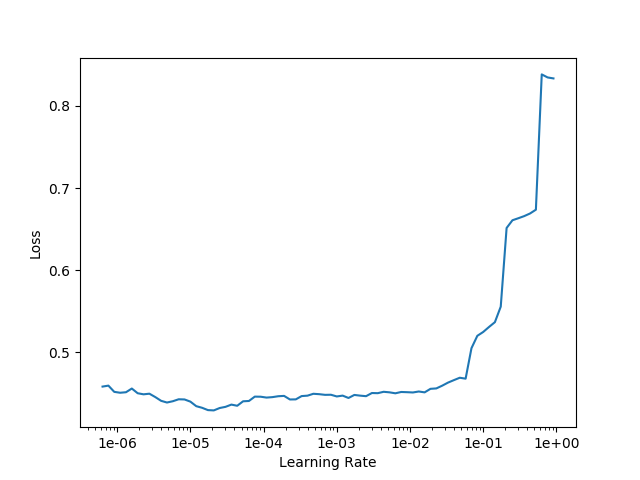

In [66]:
learner.lr_find()
learner.recorder.plot()

In [73]:
learner.fit_one_cycle(2, max_lr=3e-3)
# learner.fit(15, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.637593,0.555765,0.738674,00:53
1,0.513836,0.481081,0.780039,00:53


In [76]:
interp = learner.interpret()

In [77]:
interp.most_confused()

AttributeError: 'MultiDataset' object has no attribute 'classes'